In [ ]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [ ]:
!pip install transformers
!pip install plot_keras_history
!pip install -q sentencepiece
!pip install -q  ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9455 sha256=f920ed4255eb793fc444efa4d18cda5c065a315514ba80d307f630ad0c51b254
  Stored in directory: /root/.cache/pip/wheels/2f/31/6c/bbc9703b7baa8bd3802a8aedd9e2f9e66941b0cf0d456ab4cc
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.50-py3-none-any.whl size=320498 sha256=1f48354818e7ad25a9667bda9c8aa85bb20e14259fd98

In [ ]:
import pandas as pd
import numpy as np
import nlpaug.augmenter.word as nlpaw
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import random
def set_random_seed(seed=123):
  random.seed(seed)
  np.random.seed(seed)

set_random_seed()

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/info/titles_with_labels.csv", sep='\t', lineterminator='\n')
df.fillna('', inplace=True)
df.drop(columns = ['Unnamed: 0'], inplace=True)

df.head()

,title,label_sn,label_di,label_tb,label_va,agg_label,tokenised
0,House Republicans Fret About Winning Their Hea...,1,0.571429,0.375,0.7650,1,house republican fret winning health care suit
1,Rift Between Officers and Residents as Killing...,-1,-0.285714,0.000,-0.6597,0,rift officer resident killing persist south bronx
2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",0,-0.125000,0.000,-0.1280,0,tyrus wong bambi artist thwarted racial bias dy
3,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",1,-0.333333,-0.100,-0.5994,0,among death heavy toll pop music
4,Kim Jong-un Says North Korea Is Preparing to T...,-1,-0.111111,0.000,0.0000,-1,kim jong un say north korea preparing test lon...


In [ ]:
df.shape

(142570, 7)

In [ ]:
# Features and Labels
X = df['tokenised']
y = pd.get_dummies(df['agg_label']).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
# Get the text
train_examples_list = X_train.tolist()
test_examples_list = X_test.tolist()

train_targets_list = y_train.tolist()
test_targets_list = y_test.tolist()

In [ ]:
from transformers import DistilBertTokenizer
import tqdm

PAD_LENGTH = 256
bert = 'distilbert-base-uncased'
BATCH_SIZE = 512
EPOCHS =10

# Defining DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(bert, do_lower_case=True, add_special_tokens=True,
                                                max_length=PAD_LENGTH, padding='max_length', truncation=True)

def tokenize(sentences, tokenizer, pad_length=PAD_LENGTH):
    if type(sentences) == str:
        inputs = tokenizer.encode_plus(sentences, add_special_tokens=True, max_length=pad_length, padding='max_length', truncation=True,
                                             return_attention_mask=True, return_token_type_ids=True)
        return np.asarray(inputs['input_ids'], dtype='int32'), np.asarray(inputs['attention_mask'], dtype='int32'), np.asarray(inputs['token_type_ids'], dtype='int32')
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=pad_length, padding='max_length', truncation=True,
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])

    return (np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32'))


In [ ]:
def get_bert_inputs(examples_list, targets):
  input_ids=list()
  attention_masks=list()

  bert_inp=tokenize(examples_list, tokenizer)
  input_ids = bert_inp[0]
  attention_masks = bert_inp[1]

  targets = np.array(targets)

  return input_ids, attention_masks, targets

In [ ]:
train_input_ids, train_attention_masks, train_targets = get_bert_inputs(train_examples_list, train_targets_list)
test_input_ids, test_attention_masks, test_targets = get_bert_inputs(test_examples_list, test_targets_list)

In [ ]:
def get_labels():

		# load labels
		labels = open("/content/drive/MyDrive/Colab Notebooks/labels.csv").read().strip().split("\n")[1:]
		labels = [s.split(";")[1] for s in labels]

		return labels

In [ ]:
from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard

def write_report(report):

		file = open("/content/drive/MyDrive/reports/bert/test_report_" + datetime.now().strftime("%Y%m%d-%H%M") + ".md", "a")

		file.write(str(report))
		file.write("\n")
		file.close()

		print("[INFO] report written")

In [ ]:
import matplotlib.pyplot as plt

def plot_acc(model):

		# close previous plot
		plt.close()

		plot_history(model.history)
		plt.title('Accuracy')

		plt.legend()
		plt.tight_layout()

		plt.savefig("/content/drive/MyDrive/plots/bert/plot_acc_" + datetime.now().strftime("%Y%m%d-%H%M"))
		write_report("![](../plots/bert/plot_acc_" + datetime.now().strftime("%Y%m%d-%H%M")+ ".png)")

In [ ]:
def save_m(model):

  model.save("/content/drive/MyDrive/output/bert/bert_" + datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
import keras
import numpy as np
import random
import matplotlib.pyplot as plt

from keras.layers.core import Dense
from tensorflow.keras.layers import Dropout
from keras.layers import Input, GlobalAveragePooling1D
from keras.models import Model
from keras import backend as K

In [ ]:
from transformers import TFDistilBertModel, DistilBertConfig
from transformers.models.gpt_neox.modeling_gpt_neox import attention_mask_func
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification

id2label = {0: "Negative", 1: "Positive", -1: "Neutral"}
label2id = {"Negative": 0, "Positive": 1, "Neutral": -1}


class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

def get_BERT_layer():
  config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3, id2label=id2label, label2id=label2id)

  return model

def create_regression_BoW_bert():

  hdepth=16
  MAX_SEQUENCE_LENGTH = 256
  EMBED_SIZE=100

  # create input layer
  input_ids = Input(shape=(256,), dtype='int32')
  input_masks_ids = Input(shape=(256,), dtype='int32')

  # get BERT layer
  bert = get_BERT_layer()

  # create bert layer
  bert_layer = bert(input_ids, attention_mask=input_masks_ids)[0]
  dropout = Dropout(0.2)(bert_layer)

  # add hidden neurons
  hidden_layer = Dense(hdepth, input_shape=(MAX_SEQUENCE_LENGTH, EMBED_SIZE), activation='relu')(dropout)

  # add output layer
  out_reg = Dense(3, input_shape=(3,), activation='softmax')(hidden_layer)

  # return model
  return tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs=[out_reg])

In [ ]:
def get_model(use_tpu=True, use_gpu=False, learning_rate=1e-5):
  if use_tpu:
    # Create distribution strategy
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)

    # Create model on TPU:
    with strategy.scope():
      model = create_regression_BoW_bert()
      opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
      model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  elif use_gpu:
    device_name = tf.test.gpu_device_name()
    print(device_name)
    with tf.device('/device:GPU:0'):
      model = create_regression_BoW_bert()
      opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
      model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  else:
    model = create_regression_BoW_bert()
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(opt=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model


model = get_model()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  66955779   ['input_1[0][0]',                
 assification (TFDistilBertForS  rOutput(loss=None,               'input_2[0][0]']                
 equenceClassification)         logits=(None, 3),                                                 
                                 hidden_states=None                                           

In [ ]:
print(tf.executing_eagerly())

True


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience=3)
#log_dir = "/content/drive/MyDrive/logs/fit_bert/" + datetime.now().strftime("%Y%m%d-%H%M%S")
#tb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


history = model.fit([train_input_ids, train_attention_masks],
                    train_targets,
                    validation_data=([test_input_ids,test_attention_masks], test_targets),
                    epochs=50,
                    batch_size=BATCH_SIZE,
                    callbacks=[callback],
                    verbose=1)

Epoch 1/50
223/223 [==============================] - 179s 568ms/step - loss: 0.9524 - accuracy: 0.5230 - val_loss: 0.7851 - val_accuracy: 0.6150
Epoch 2/50
223/223 [==============================] - 85s 380ms/step - loss: 0.7827 - accuracy: 0.6079 - val_loss: 0.6983 - val_accuracy: 0.6540
Epoch 3/50
223/223 [==============================] - 85s 380ms/step - loss: 0.7103 - accuracy: 0.6400 - val_loss: 0.6584 - val_accuracy: 0.6974
Epoch 4/50
223/223 [==============================] - 85s 381ms/step - loss: 0.6650 - accuracy: 0.6855 - val_loss: 0.6268 - val_accuracy: 0.7783
Epoch 5/50
223/223 [==============================] - 85s 381ms/step - loss: 0.6290 - accuracy: 0.7437 - val_loss: 0.6173 - val_accuracy: 0.7990
Epoch 6/50
223/223 [==============================] - 85s 380ms/step - loss: 0.6011 - accuracy: 0.7944 - val_loss: 0.5948 - val_accuracy: 0.8257
Epoch 7/50
223/223 [==============================] - 85s 380ms/step - loss: 0.5798 - accuracy: 0.8207 - val_loss: 0.5934 - val_a

In [ ]:
results = model.evaluate([test_input_ids,test_attention_masks], test_targets)
print('Test loss:', results[0])
print('Test Accuracy:', results[1])

892/892 [==============================] - 26s 25ms/step - loss: 0.5926 - accuracy: 0.8497
Test loss: 0.5925592184066772
Test Accuracy: 0.8496878743171692


In [ ]:
from sklearn.metrics import classification_report

# get labels
labels = get_labels()

# test model
predictions = model.predict([test_input_ids,test_attention_masks])
report = classification_report(test_targets.argmax(axis=1), np.argmax(predictions, axis=1), target_names=labels)
print(report)
write_report(report)

892/892 [==============================] - 24s 24ms/step
              precision    recall  f1-score   support

    Negative       0.91      0.65      0.76      8473
    Positive       0.85      0.94      0.89     10928
     Neutral       0.82      0.93      0.87      9113

    accuracy                           0.85     28514
   macro avg       0.86      0.84      0.84     28514
weighted avg       0.86      0.85      0.84     28514

[INFO] report written


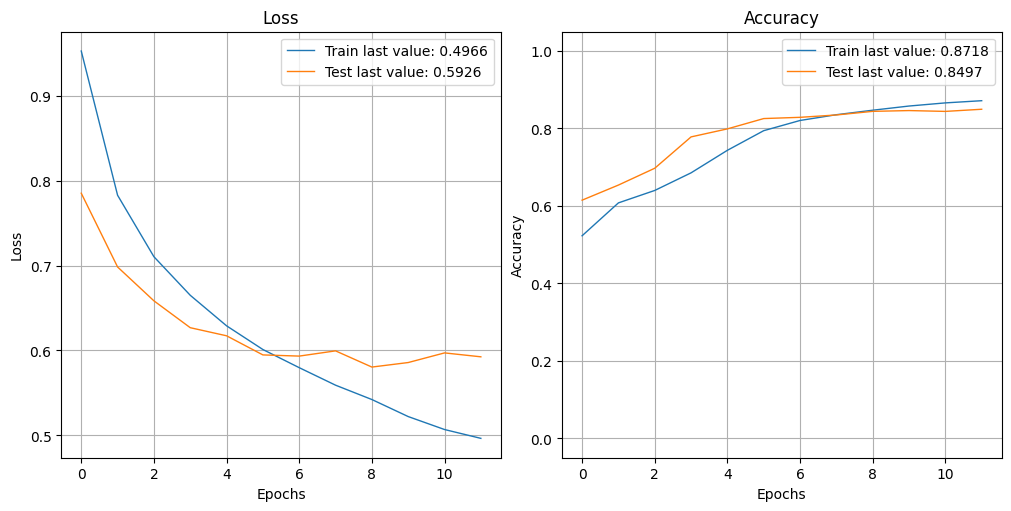

<ipython-input-15-4a71a01cdeb6>:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


[INFO] report written


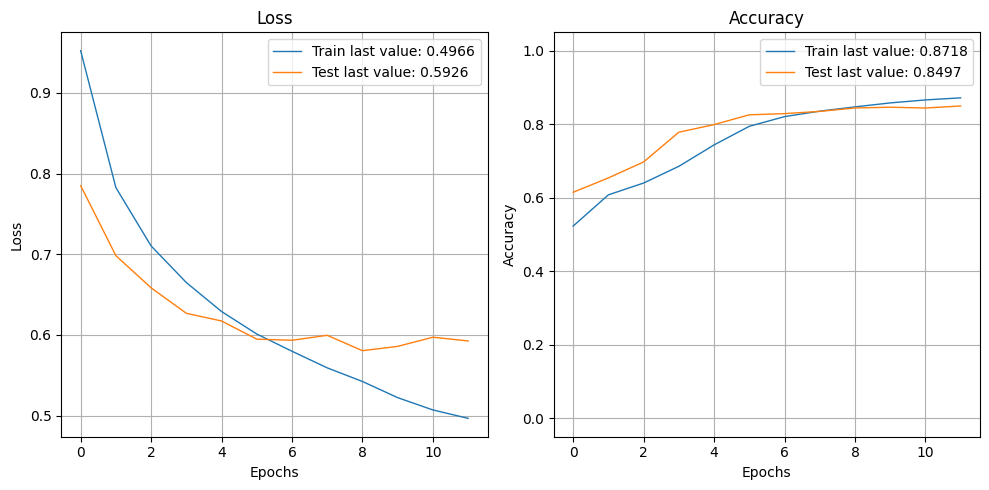

In [ ]:
from plot_keras_history import plot_history
plot_history(history.history, path="std.png")
plt.show()

plot_acc(history)

In [ ]:
preds = model.predict(
      [test_input_ids,test_attention_masks],
      batch_size=None,
      verbose="auto",
      steps=None,
      callbacks=None,
      max_queue_size=10,
      workers=1,
      use_multiprocessing=False)

preds = np.array(preds).flatten()

892/892 [==============================] - 16s 18ms/step


In [ ]:
!pip install -q ekphrasis
!pip3 install -q emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# import library packages
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

# create the text preprocessor
text_processor = TextPreProcessor(

    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],

    fix_html=True,  # fix HTML tokens

    # corpus from which the word statistics are going to be used
    # for word segmentation
    segmenter="twitter",

    # corpus from which the word statistics are going to be used
    # for spell correction
    corrector="twitter",

    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words

    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,

    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

/usr/local/lib/python3.10/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading twitter - 1grams ...


/usr/local/lib/python3.10/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [ ]:
new_train_examples_list = [" ".join(text_processor.pre_process_doc(example)) for example in train_examples_list]
new_test_examples_list = [" ".join(text_processor.pre_process_doc(example)) for example in test_examples_list]


In [ ]:
print("Original Text:", train_examples_list[0])
print("Preprocessed Text:", new_train_examples_list[0])

Original Text: place troop close isi
Preprocessed Text: place troop close isi


In [ ]:
train_input_ids, train_attention_masks, train_targets = get_bert_inputs(new_train_examples_list, train_targets_list)
test_input_ids, test_attention_masks, test_targets = get_bert_inputs(new_test_examples_list, test_targets_list)

model = get_model()

history = model.fit([train_input_ids, train_attention_masks],
                    train_targets,
                    validation_data=([test_input_ids,test_attention_masks], test_targets),
                    epochs=50,
                    batch_size=BATCH_SIZE,
                    callbacks=[callback],
                    verbose=1)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/50
223/223 [==============================] - 180s 567ms/step - loss: 0.9708 - accuracy: 0.5134 - val_loss: 0.7552 - val_accuracy: 0.7083
Epoch 2/50
223/223 [==============================] - 85s 380ms/step - loss: 0.7614 - accuracy: 0.6598 - val_loss: 0.5948 - val_accuracy: 0.7813
Epoch 3/50
223/223 [==============================] - 85s 381ms/step - loss: 0.6535 - accuracy: 0.7251 - val_loss: 0.5191 - val_accuracy: 0.8083
Epoch 4/50
223/223 [==============================] - 85s 383ms/step - loss: 0.5880 - accuracy: 0.7527 - val_loss: 0.4702 - val_accuracy: 0.8254
Epoch 5/50
223/223 [==============================] - 87s 389ms/step - loss: 0.5365 - accuracy: 0.7718 - val_loss: 0.4300 - val_accuracy: 0.8461
Epoch 6/50
223/223 [==============================] - 87s 389ms/step - loss: 0.5019 - accuracy: 0.7846 - val_loss: 0.4043 - val_accuracy: 0.8550
Epoch 7/50
223/223 [==============================] - 86s 388ms/step - loss: 0.4718 - accuracy: 0.7960 - val_loss: 0.3896 - val_a

In [ ]:
results = model.evaluate([test_input_ids,test_attention_masks], test_targets)
print('Test loss:', results[0])
print('Test Accuracy:', results[1])

892/892 [==============================] - 33s 32ms/step - loss: 0.3726 - accuracy: 0.8674
Test loss: 0.37259185314178467
Test Accuracy: 0.8673633933067322


In [ ]:
from sklearn.metrics import classification_report

# get labels
labels = get_labels()

# test model
predictions = model.predict([test_input_ids,test_attention_masks])
report = classification_report(test_targets.argmax(axis=1), np.argmax(predictions, axis=1), target_names=labels)
print(report)
write_report(report)

892/892 [==============================] - 31s 27ms/step
              precision    recall  f1-score   support

    Negative       0.83      0.79      0.81      8473
    Positive       0.87      0.94      0.91     10928
     Neutral       0.90      0.85      0.88      9113

    accuracy                           0.87     28514
   macro avg       0.87      0.86      0.86     28514
weighted avg       0.87      0.87      0.87     28514

[INFO] report written


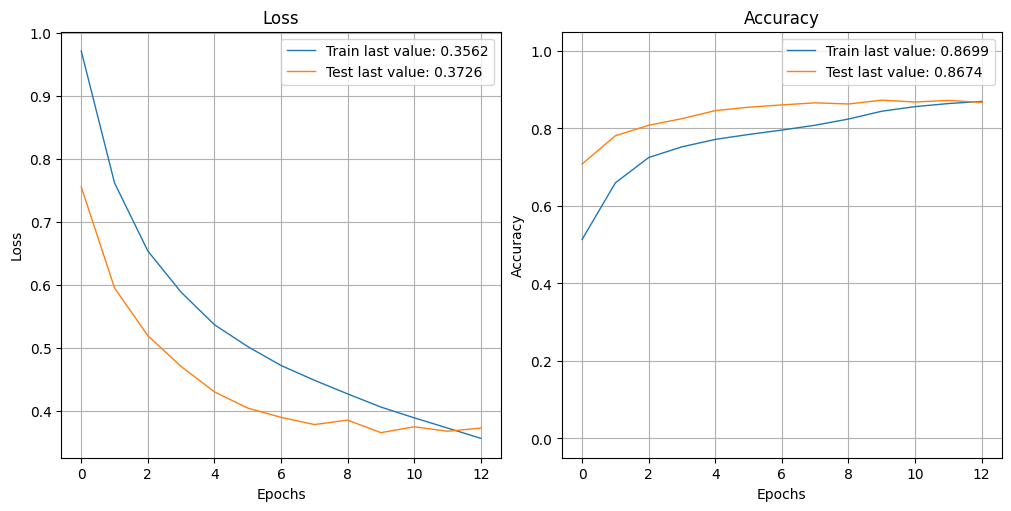

<ipython-input-15-4a71a01cdeb6>:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


[INFO] report written


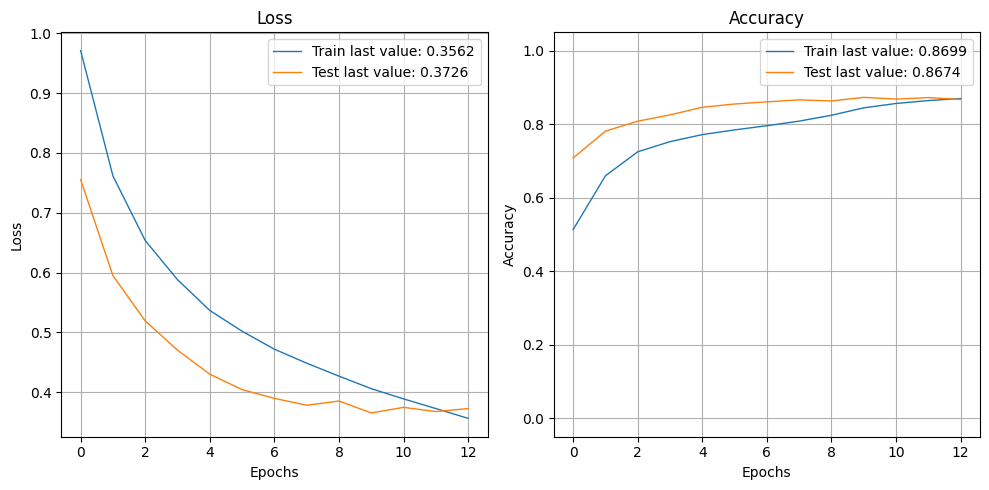

In [ ]:
plot_history(history.history, path="std.png")
plt.show()

plot_acc(history)

In [ ]:
import nlpaug.augmenter.word as naw

# create augmentation
syn_aug = naw.SynonymAug(aug_src='wordnet')
rand_aug = naw.RandomWordAug()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# create data for synonym augmentation
syn_train_examples_list = [" ".join(syn_aug.augment(example)) for example in train_examples_list]
syn_test_examples_list = [" ".join(syn_aug.augment(example)) for example in test_examples_list]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# create data for random deletion augmentation
rand_train_examples_list = [" ".join(rand_aug.augment(example)) for example in train_examples_list]
rand_test_examples_list = [" ".join(rand_aug.augment(example)) for example in test_examples_list]

In [ ]:
# show synonym augmentation example
print("Original Text:", train_examples_list[0])
print("Augmented Text:", syn_train_examples_list[0])

Original Text: place troop close isi
Augmented Text: place troop tight isi


In [ ]:
# show random deletion augmentation example
print("Original Text:", train_examples_list[0])
print("Augmented Text:", rand_train_examples_list[0])

Original Text: place troop close isi
Augmented Text: troop isi


In [ ]:
# create data for both augmentations
both_train_examples_list = [" ".join(rand_aug.augment(example)) for example in syn_train_examples_list]
both_test_examples_list = [" ".join(rand_aug.augment(example)) for example in syn_test_examples_list]

In [ ]:
# show example after augmenting twice
print("Original Text:", train_examples_list[0])
print("Augmented Text:", both_train_examples_list[0])

Original Text: place troop close isi
Augmented Text: place tight


In [ ]:
# get inputs for all three versions
# s = synonym augmentation
# r = random word deletion
# b = both of the above
s_train_input_ids, s_train_attention_masks, s_train_targets = get_bert_inputs(syn_train_examples_list, train_targets_list)
s_test_input_ids, s_test_attention_masks, s_test_targets = get_bert_inputs(syn_test_examples_list, test_targets_list)

r_train_input_ids, r_train_attention_masks, r_train_targets = get_bert_inputs(rand_train_examples_list, train_targets_list)
r_test_input_ids, r_test_attention_masks, r_test_targets = get_bert_inputs(rand_test_examples_list, test_targets_list)

b_train_input_ids, b_train_attention_masks, b_train_targets = get_bert_inputs(both_train_examples_list, train_targets_list)
b_test_input_ids, b_test_attention_masks, b_test_targets = get_bert_inputs(both_test_examples_list, test_targets_list)


In [ ]:
print("Training examples before augmentation:")
print(len(X_train.tolist()))
print("Training examples after augmentation:")
print(len(syn_train_examples_list))
print(len(rand_train_examples_list))
print(len(both_train_examples_list))

Training examples before augmentation:
114056
Training examples after augmentation:
114056
114056
114056


In [ ]:
print("Length of first entry of the dataset before augmentation:")
print(len(X_train.tolist()[0]))
print("Length of first entry of the dataset after augmentation:")
print(len(syn_train_examples_list[0]))
print(len(rand_train_examples_list[0]))
print(len(both_train_examples_list[0]))

Length of first entry of the dataset before augmentation:
21
Length of first entry of the dataset after augmentation:
21
9
11


In [ ]:
# train with synonym augmentation only
s_model = get_model()

s_history = s_model.fit([s_train_input_ids, s_train_attention_masks],
                    s_train_targets,
                    validation_data=([s_test_input_ids,s_test_attention_masks], s_test_targets),
                    epochs=50,
                    batch_size=BATCH_SIZE,
                    callbacks=[callback],
                    verbose=1)



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/50
223/223 [==============================] - 193s 591ms/step - loss: 0.9711 - accuracy: 0.5244 - val_loss: 0.8306 - val_accuracy: 0.6450
Epoch 2/50
223/223 [==============================] - 86s 386ms/step - loss: 0.8309 - accuracy: 0.6456 - val_loss: 0.7593 - val_accuracy: 0.6855
Epoch 3/50
223/223 [==============================] - 86s 385ms/step - loss: 0.7652 - accuracy: 0.6831 - val_loss: 0.7099 - val_accuracy: 0.7084
Epoch 4/50
223/223 [==============================] - 86s 385ms/step - loss: 0.7192 - accuracy: 0.7061 - val_loss: 0.6802 - val_accuracy: 0.7239
Epoch 5/50
223/223 [==============================] - 86s 385ms/step - loss: 0.6844 - accuracy: 0.7235 - val_loss: 0.6718 - val_accuracy: 0.7310
Epoch 6/50
223/223 [==============================] - 86s 384ms/step - loss: 0.6508 - accuracy: 0.7372 - val_loss: 0.6585 - val_accuracy: 0.7372
Epoch 7/50
223/223 [==============================] - 86s 384ms/step - loss: 0.6252 - accuracy: 0.7506 - val_loss: 0.6536 - val_a

In [ ]:
s_results = s_model.evaluate([np.asarray(s_test_input_ids),np.asarray(s_test_attention_masks)], s_test_targets)
print('Test loss:', s_results[0])
print('Test Accuracy:', s_results[1])

892/892 [==============================] - 26s 25ms/step - loss: 0.6782 - accuracy: 0.7438
Test loss: 0.6782233119010925
Test Accuracy: 0.7438451051712036


In [ ]:
from sklearn.metrics import classification_report

# get labels
labels = get_labels()

# test model
s_predictions = s_model.predict([s_test_input_ids,s_test_attention_masks])
s_report = classification_report(s_test_targets.argmax(axis=1), np.argmax(s_predictions, axis=1), target_names=labels)
print(s_report)
write_report(s_report)

892/892 [==============================] - 25s 25ms/step
              precision    recall  f1-score   support

    Negative       0.74      0.58      0.65      8473
    Positive       0.77      0.81      0.79     10928
     Neutral       0.72      0.82      0.76      9113

    accuracy                           0.74     28514
   macro avg       0.74      0.74      0.73     28514
weighted avg       0.74      0.74      0.74     28514

[INFO] report written


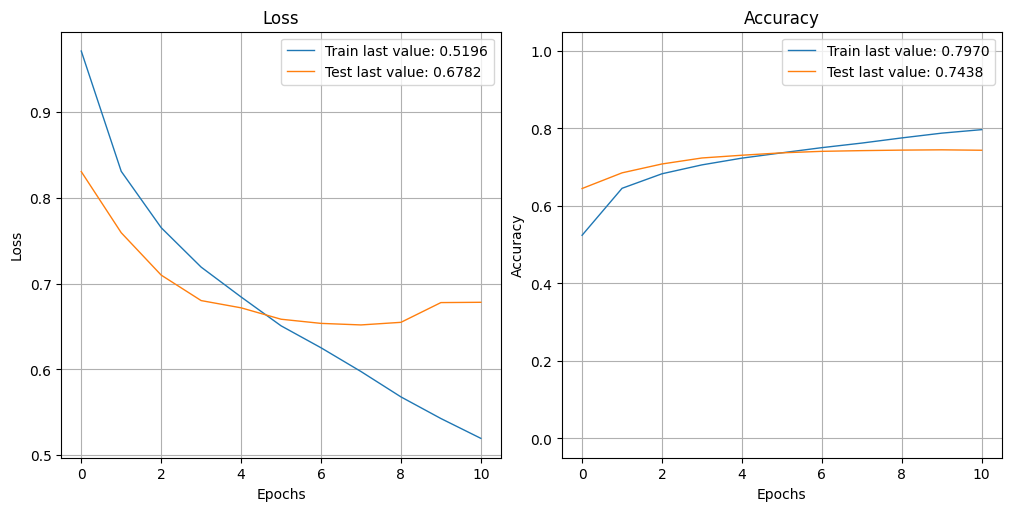

<ipython-input-15-4a71a01cdeb6>:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


[INFO] report written


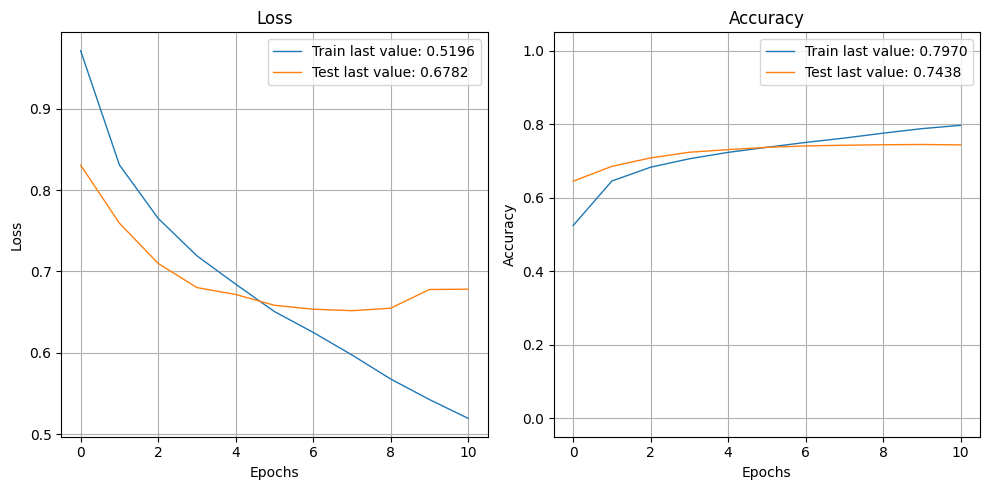

In [ ]:
plot_history(s_history.history, path="std.png")
plt.show()

plot_acc(s_history)

In [ ]:
# train with random word deletion augmentation only
r_model = get_model()

r_history = r_model.fit([r_train_input_ids, r_train_attention_masks],
                    r_train_targets,
                    validation_data=([r_test_input_ids,r_test_attention_masks], r_test_targets),
                    epochs=50,
                    batch_size=BATCH_SIZE,
                    callbacks=[callback],
                    verbose=1)



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/50
223/223 [==============================] - 184s 580ms/step - loss: 1.0052 - accuracy: 0.4944 - val_loss: 0.8774 - val_accuracy: 0.6270
Epoch 2/50
223/223 [==============================] - 85s 381ms/step - loss: 0.9035 - accuracy: 0.5776 - val_loss: 0.8065 - val_accuracy: 0.6715
Epoch 3/50
223/223 [==============================] - 85s 381ms/step - loss: 0.8556 - accuracy: 0.6038 - val_loss: 0.7766 - val_accuracy: 0.6861
Epoch 4/50
223/223 [==============================] - 85s 381ms/step - loss: 0.8280 - accuracy: 0.6171 - val_loss: 0.7546 - val_accuracy: 0.6941
Epoch 5/50
223/223 [==============================] - 85s 381ms/step - loss: 0.8034 - accuracy: 0.6276 - val_loss: 0.7472 - val_accuracy: 0.6952
Epoch 6/50
223/223 [==============================] - 85s 381ms/step - loss: 0.7832 - accuracy: 0.6398 - val_loss: 0.7354 - val_accuracy: 0.7009
Epoch 7/50
223/223 [==============================] - 85s 381ms/step - loss: 0.7658 - accuracy: 0.6627 - val_loss: 0.7324 - val_a

In [ ]:
r_results = r_model.evaluate([np.asarray(r_test_input_ids),np.asarray(r_test_attention_masks)], r_test_targets)
print('Test loss:', r_results[0])
print('Test Accuracy:', r_results[1])

892/892 [==============================] - 27s 26ms/step - loss: 0.7374 - accuracy: 0.7037
Test loss: 0.7373620271682739
Test Accuracy: 0.7036893963813782


In [ ]:
from sklearn.metrics import classification_report

# get labels
labels = get_labels()

# test model
r_predictions = r_model.predict([r_test_input_ids,r_test_attention_masks])
r_report = classification_report(r_test_targets.argmax(axis=1), np.argmax(r_predictions, axis=1), target_names=labels)
print(r_report)
write_report(r_report)

892/892 [==============================] - 25s 25ms/step
              precision    recall  f1-score   support

    Negative       0.62      0.66      0.64      8473
    Positive       0.75      0.74      0.75     10928
     Neutral       0.74      0.70      0.72      9113

    accuracy                           0.70     28514
   macro avg       0.70      0.70      0.70     28514
weighted avg       0.71      0.70      0.70     28514

[INFO] report written


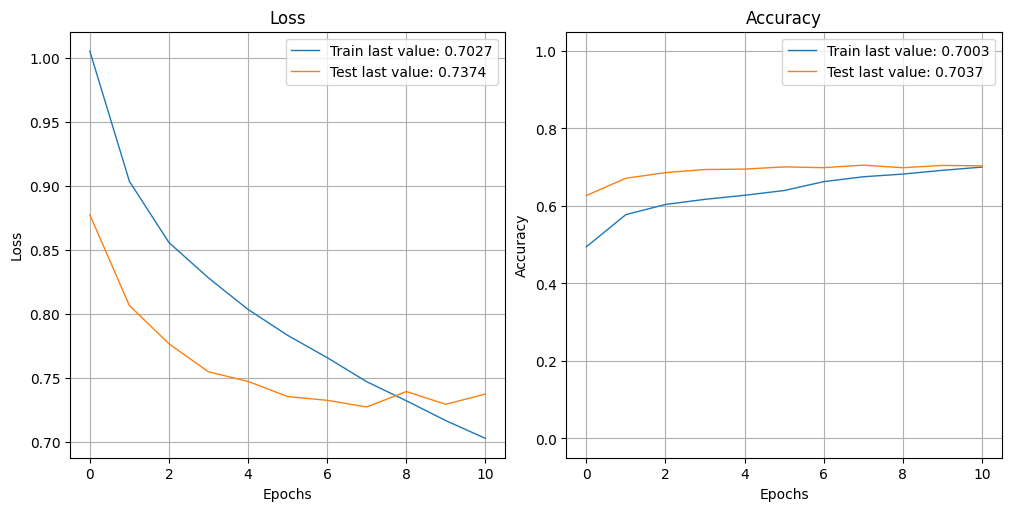

<ipython-input-15-4a71a01cdeb6>:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


[INFO] report written


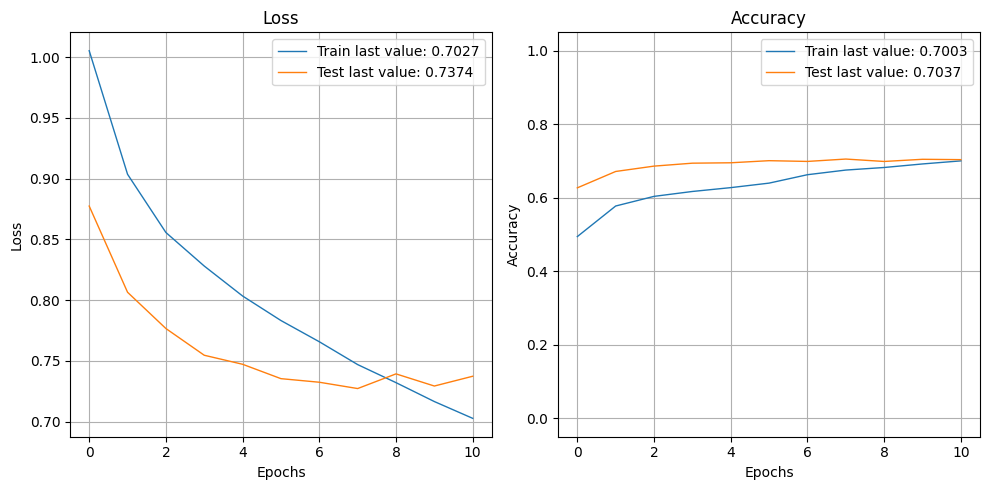

In [ ]:
plot_history(r_history.history, path="std.png")
plt.show()

plot_acc(r_history)

In [ ]:
# train with both augmentations
b_model = get_model()

b_history = b_model.fit([b_train_input_ids, b_train_attention_masks],
                    b_train_targets,
                    validation_data=([b_test_input_ids,b_test_attention_masks], b_test_targets),
                    epochs=50,
                    batch_size=BATCH_SIZE,
                    callbacks=[callback],
                    verbose=1)



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/50
223/223 [==============================] - 185s 584ms/step - loss: 1.0510 - accuracy: 0.4213 - val_loss: 0.9785 - val_accuracy: 0.5516
Epoch 2/50
223/223 [==============================] - 85s 382ms/step - loss: 0.9874 - accuracy: 0.5180 - val_loss: 0.9323 - val_accuracy: 0.5827
Epoch 3/50
223/223 [==============================] - 85s 382ms/step - loss: 0.9555 - accuracy: 0.5476 - val_loss: 0.9089 - val_accuracy: 0.5960
Epoch 4/50
223/223 [==============================] - 85s 383ms/step - loss: 0.9320 - accuracy: 0.5635 - val_loss: 0.8976 - val_accuracy: 0.6000
Epoch 5/50
223/223 [==============================] - 85s 382ms/step - loss: 0.9116 - accuracy: 0.5768 - val_loss: 0.8847 - val_accuracy: 0.6103
Epoch 6/50
223/223 [==============================] - 85s 382ms/step - loss: 0.8924 - accuracy: 0.5888 - val_loss: 0.8775 - val_accuracy: 0.6159
Epoch 7/50
223/223 [==============================] - 85s 383ms/step - loss: 0.8739 - accuracy: 0.6020 - val_loss: 0.8751 - val_a

In [ ]:
b_results = b_model.evaluate([np.asarray(b_test_input_ids),np.asarray(b_test_attention_masks)], b_test_targets)
print('Test loss:', b_results[0])
print('Test Accuracy:', b_results[1])

892/892 [==============================] - 27s 26ms/step - loss: 0.8890 - accuracy: 0.6186
Test loss: 0.8890162706375122
Test Accuracy: 0.6186084151268005


In [ ]:
from sklearn.metrics import classification_report

# get labels
labels = get_labels()

# test model
b_predictions = b_model.predict([b_test_input_ids,b_test_attention_masks])
b_report = classification_report(b_test_targets.argmax(axis=1), np.argmax(b_predictions, axis=1), target_names=labels)
print(b_report)
write_report(b_report)

892/892 [==============================] - 25s 25ms/step
              precision    recall  f1-score   support

    Negative       0.56      0.51      0.53      8473
    Positive       0.62      0.75      0.68     10928
     Neutral       0.68      0.56      0.61      9113

    accuracy                           0.62     28514
   macro avg       0.62      0.61      0.61     28514
weighted avg       0.62      0.62      0.62     28514

[INFO] report written


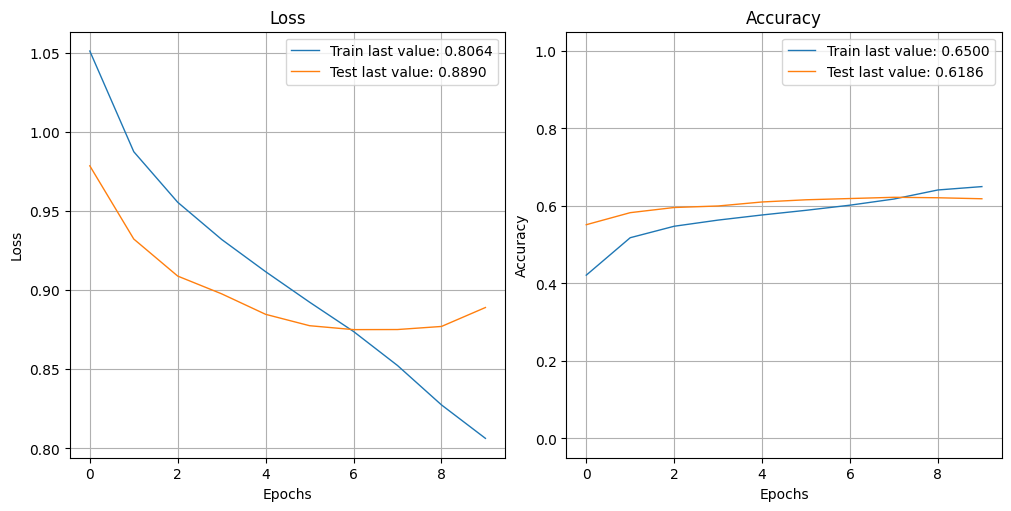

<ipython-input-15-4a71a01cdeb6>:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


[INFO] report written


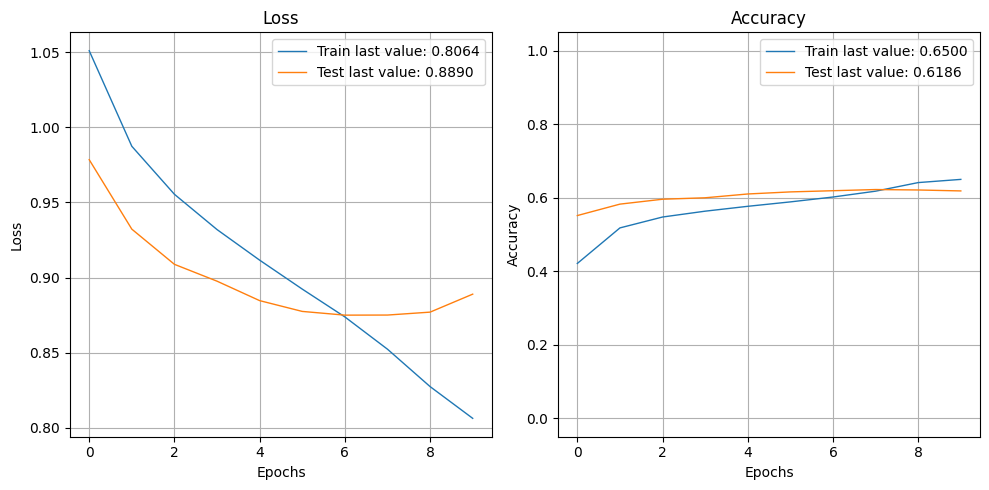

In [ ]:
plot_history(b_history.history, path="std.png")
plt.show()

plot_acc(b_history)